In [11]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.n_jobs = 10
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=100, facecolor='white', figsize=(5,5), frameon=False)

In [2]:
df_meta = pd.read_csv('../cell_metadata_with_cluster_annotation.csv', engine='pyarrow', index_col=0)
subclass_dict = df_meta['subclass'].str.split(' ').str[1:].str.join(' ').to_dict()
class_dict = df_meta['class'].str.split(' ').str[1:].str.join(' ').to_dict()

In [3]:
def read_AIBA_h5ad(region: str):
    
    adata = sc.read_h5ad(f'../data/WMB-10Xv3-{region}-log2.h5ad')
    adata.layers['counts'] = sc.read_h5ad(f'../data/WMB-10Xv3-{region}-raw.h5ad').X
    adata.layers['log2'] =  adata.X.copy()
    adata.var['gene_identifier'] = adata.var.index.astype(str).copy()
    adata.var_names = adata.var['gene_symbol'].astype(str).copy()
    adata.var_names_make_unique()
    adata.obs['subclass'] = adata.obs.index.map(subclass_dict)
    adata.obs['class'] = adata.obs.index.map(class_dict)
    
    return adata

In [4]:
adatas = list(map(read_AIBA_h5ad, ['STR','PAL']))

In [5]:
adata = sc.concat(adatas)
adata = adata[adata.obs.dropna().index].copy()

In [6]:
# remove cell classes with less than 100 cells
class_keep = adata.obs['class'].value_counts().where(lambda x: x>100).dropna().index.tolist()

In [7]:
adata = adata[adata.obs['class'].isin(class_keep)].copy()

In [8]:
del adatas

In [9]:
adata.obs['class'][adata.obs['class'].str.contains('LSX')] = adata.obs.subclass[adata.obs['class'].str.contains('LSX')]

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_66123/2604320422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['class'][adata.obs['class'].str.contains('LSX')] = adata.obs.subclass[adata.obs['class'].str.contains('LSX')]


In [15]:
adata.obs['class'] = adata.obs['class'].astype('category')

In [23]:
# subsample to 6500 cells per class
target_cells = 6500

tmp = [adata[adata.obs['class'] == s] for s in adata.obs['class'].cat.categories]

for dat in tmp:
    if dat.n_obs > target_cells:
         sc.pp.subsample(dat, n_obs=target_cells)

adata_sub = sc.concat(tmp)

adata_sub.obs['class'].value_counts()

/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1823: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


class
Astro-Epen               6500
Immune                   6500
OPC-Oligo                6500
LSX Prdm12 Zeb2 Gaba     6500
LSX Prdm12 Slit2 Gaba    6500
CNU-HYa GABA             6500
LSX Nkx2-1 Gaba          6500
CNU-LGE GABA             6500
CNU-MGE GABA             6500
CNU-HYa Glut             6500
Vascular                 6500
IT-ET Glut               5276
OB-IMN GABA              4692
LSX Otx2 Gaba            4320
LSX Sall3 Lmo1 Gaba      2507
CTX-CGE GABA             1724
LSX Sall3 Pax6 Gaba      1097
HY GABA                   973
HY Glut                   589
OB-CR Glut                552
CTX-MGE GABA              548
NP-CT-L6b Glut            363
DG-IMN Glut               288
TH Glut                   261
Name: count, dtype: int64

In [25]:
sc.pp.highly_variable_genes(adata_sub, n_top_genes=5000)
sc.pp.scale(adata_sub, max_value=10)
sc.tl.pca(adata_sub, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(adata_sub, n_neighbors=100, n_pcs=50)
sc.tl.leiden(adata_sub, resolution=0.1)
sc.tl.umap(adata_sub)

/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [26]:
lsx = adata_sub.obs['class'][adata_sub.obs['class'].str.contains('LSX')].unique()

/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


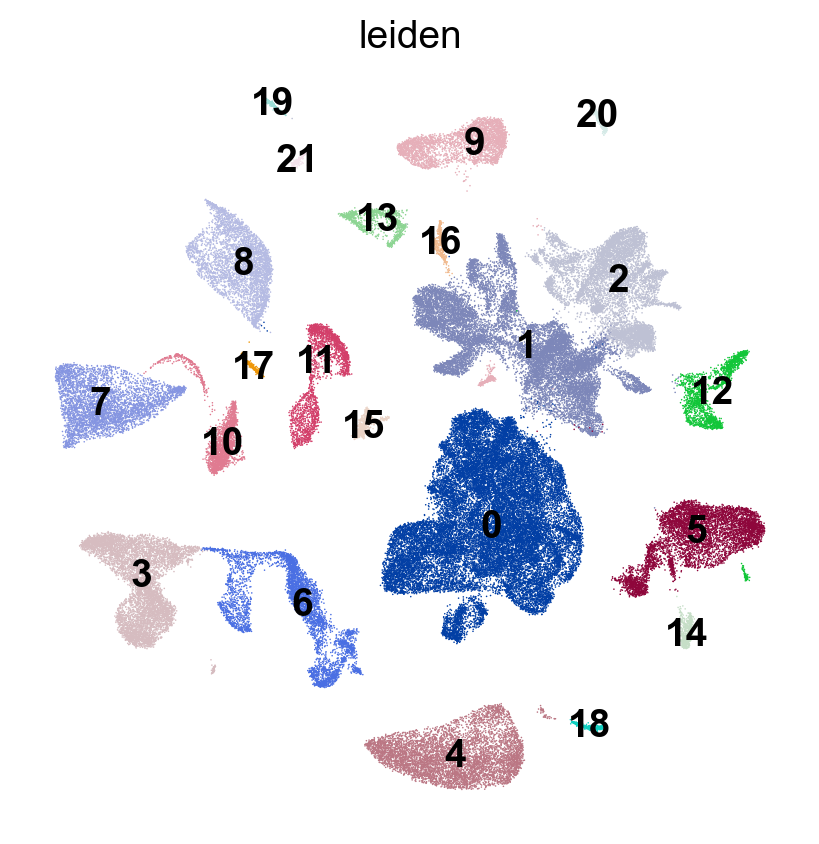

/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


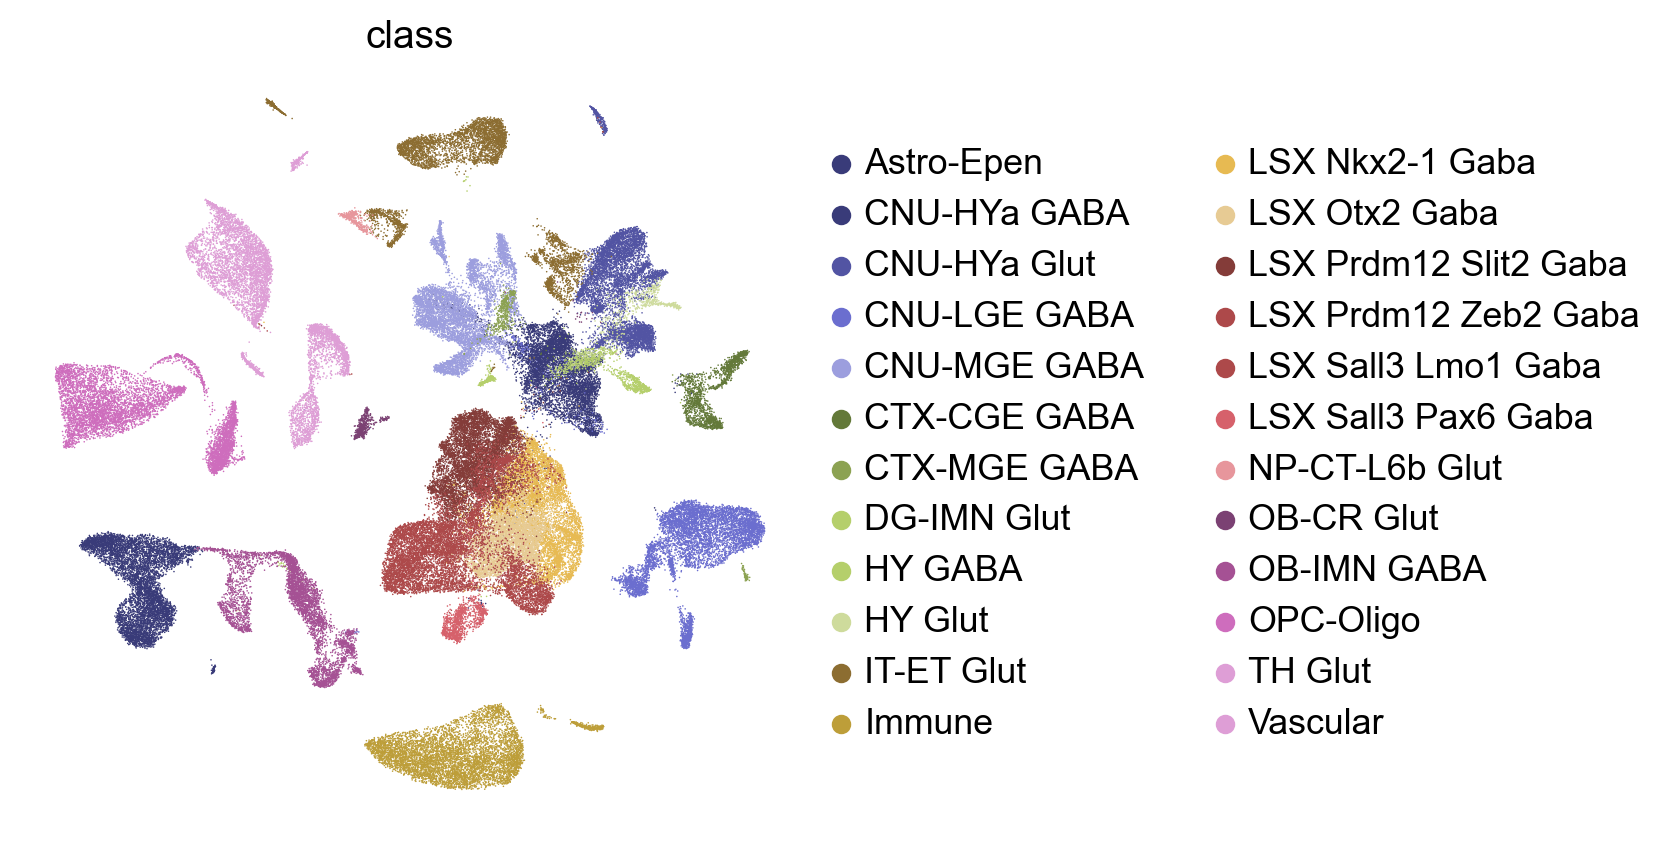

/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3

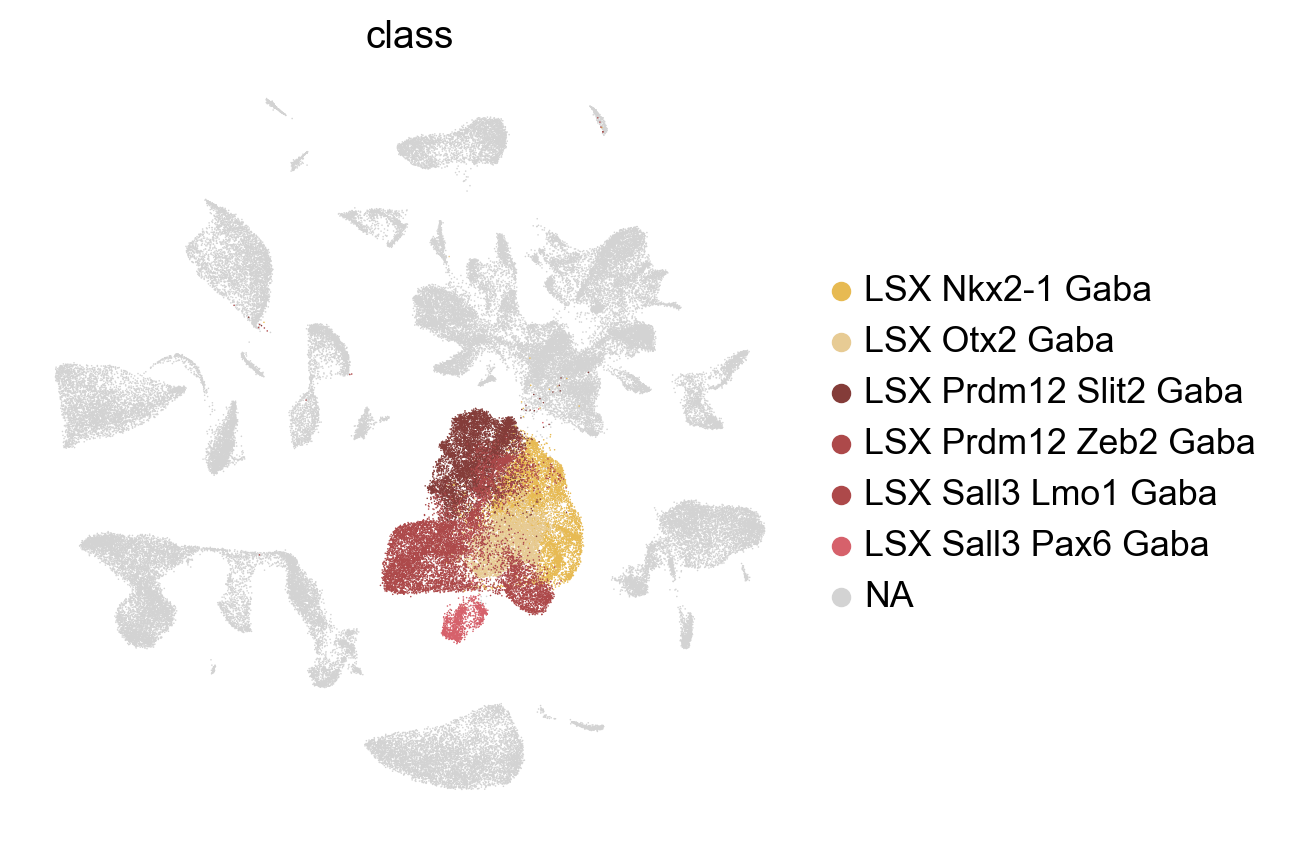

/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


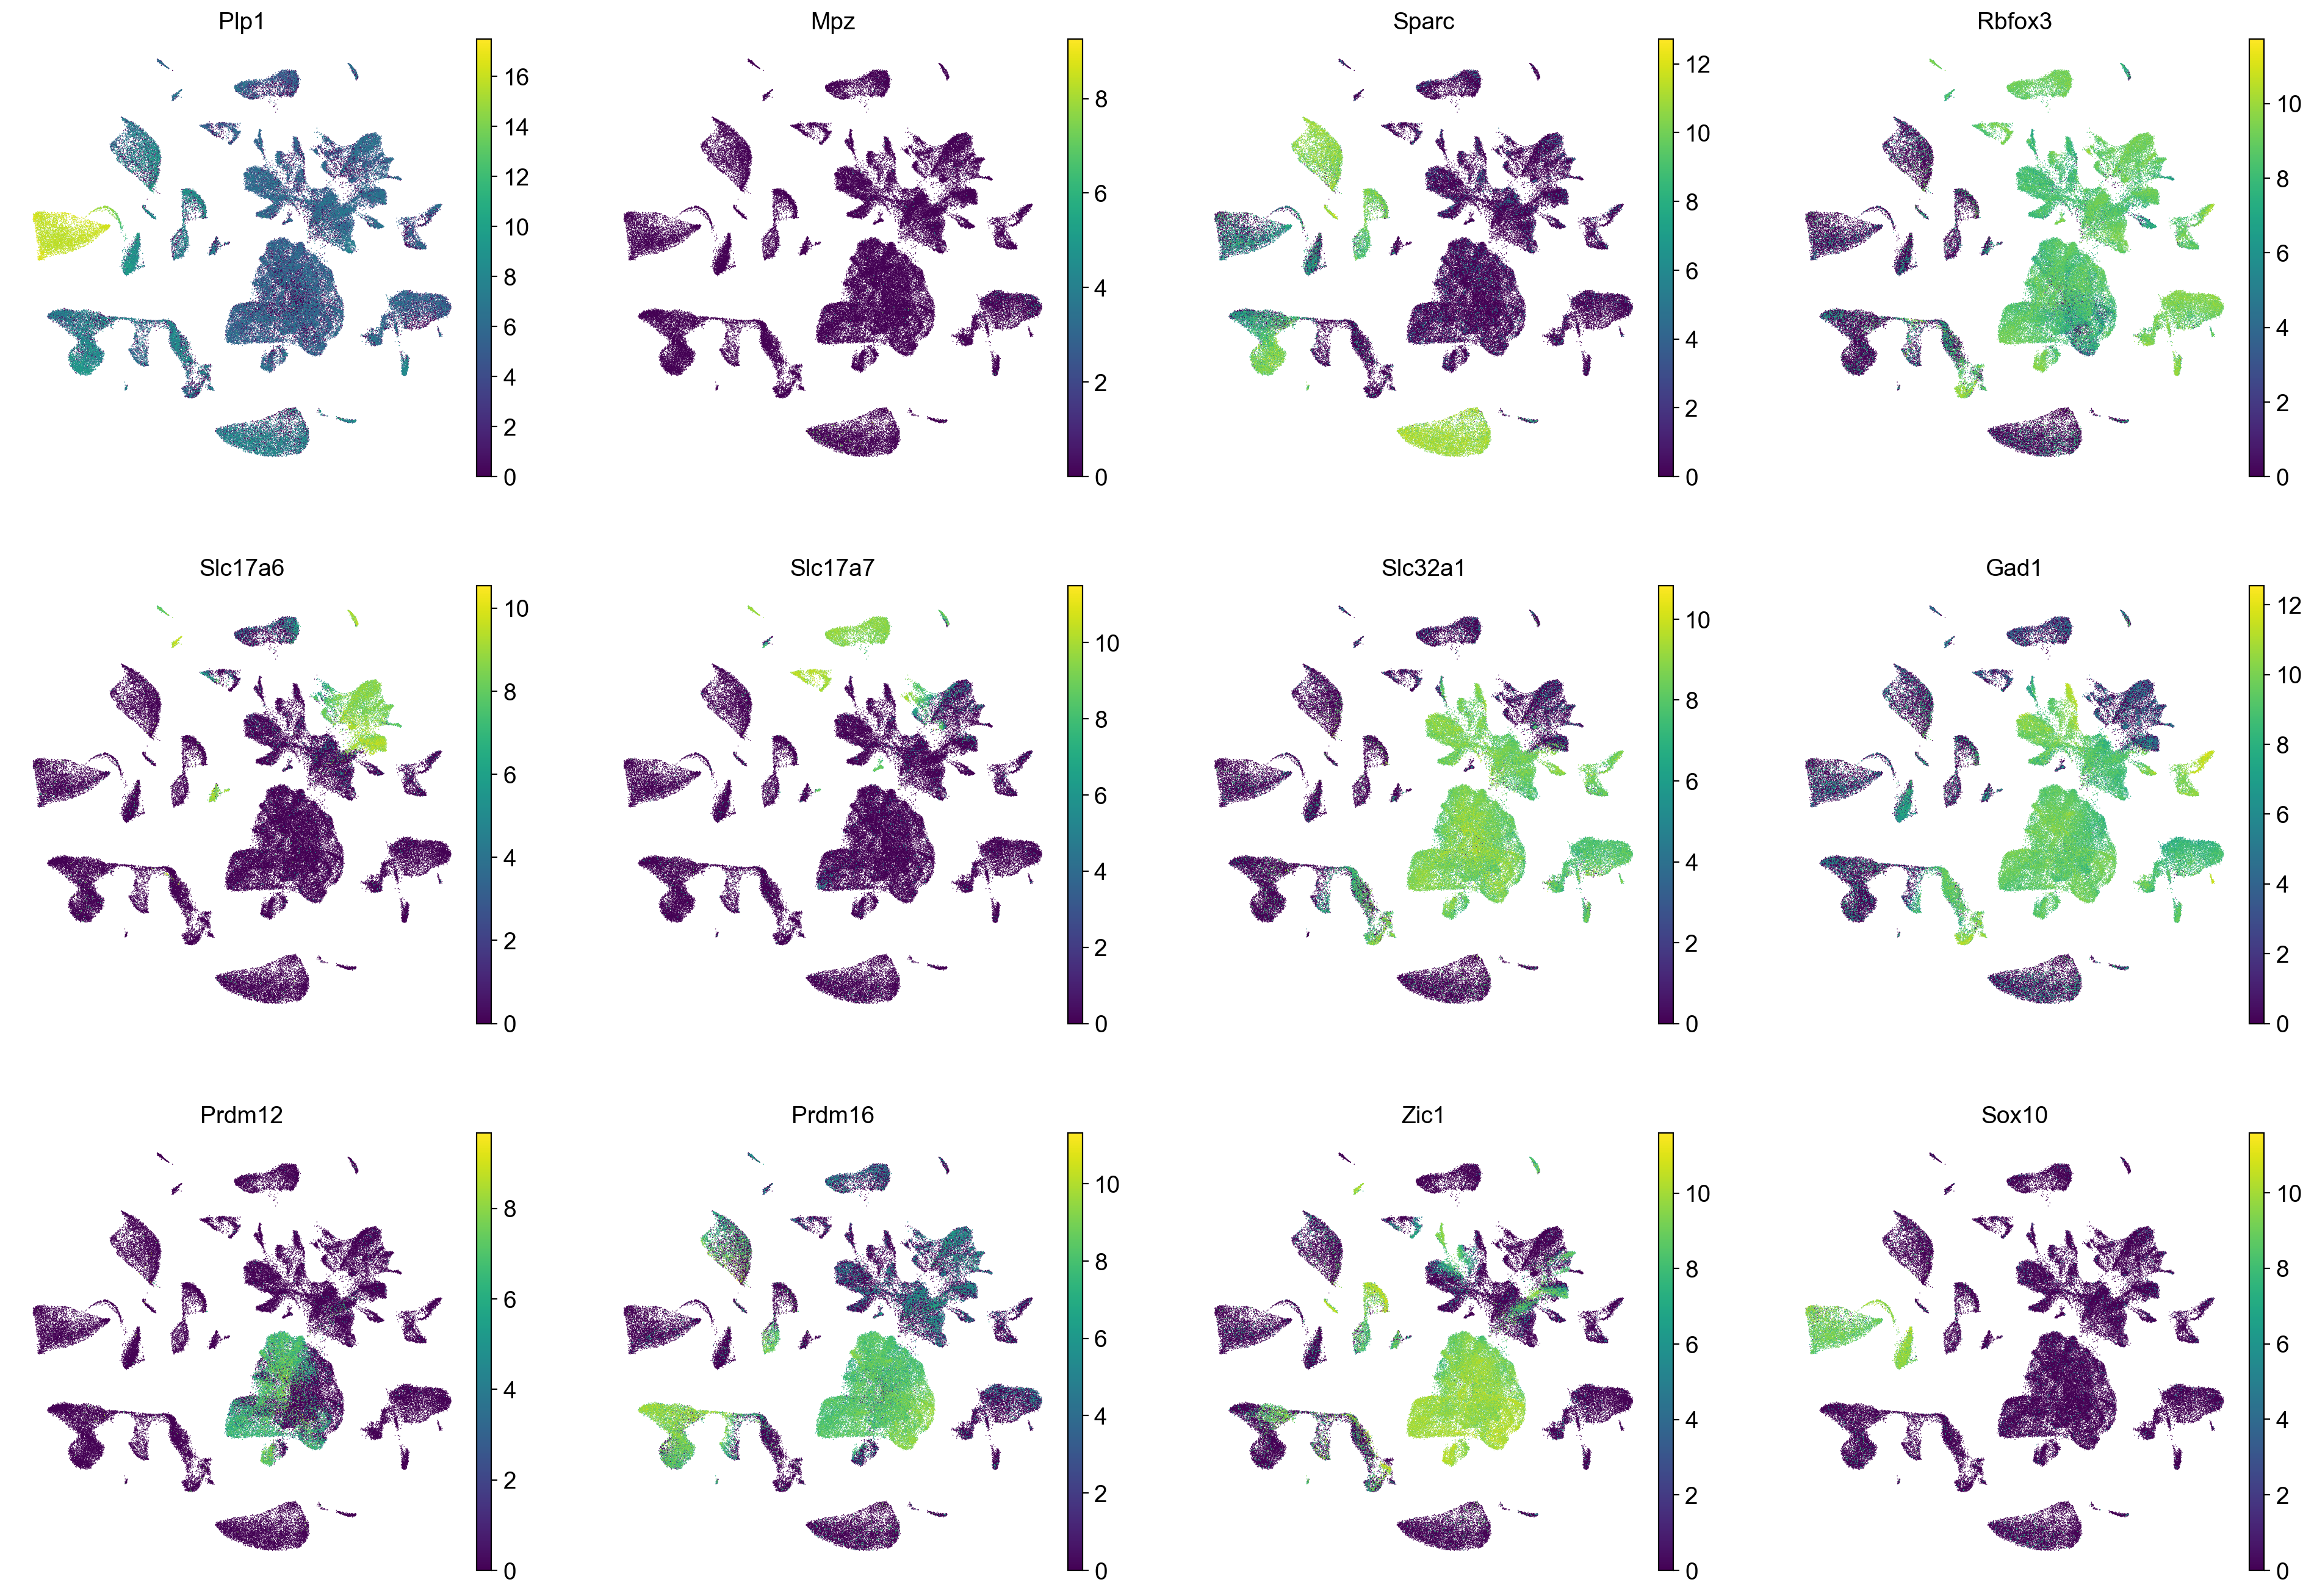

In [27]:
sc.pl.umap(adata_sub, color=['leiden'], legend_loc='on data')
sc.pl.umap(adata_sub, color=['class'], palette='tab20b')
sc.pl.umap(adata_sub, color=['class'], groups=lsx)
sc.pl.umap(adata_sub, color=['Plp1','Mpz','Sparc','Rbfox3','Slc17a6','Slc17a7','Slc32a1','Gad1','Prdm12','Prdm16','Zic1','Sox10'], layer='log2', vmin=0)

In [34]:
sc.tl.rank_genes_groups(adata_sub, groupby='class', method='t-test_overestim_var', use_raw=False, layer='log2')

/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: Performanc

In [35]:
class_mk = sc.get.rank_genes_groups_df(adata_sub, group=None, log2fc_min=0, pval_cutoff=0.05)

In [36]:
class_mk.to_excel('./Results_table/03_scRNA_10x_AIBA_class_mk.xlsx')

In [38]:
adata_sub.write_h5ad('./Results_h5ad/03_scRNA_10x_AIBA_subsample.h5ad')